In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, Flatten, Input, Reshape
from keras.callbacks import EarlyStopping
from scipy.integrate import odeint 
import time

In [ ]:
def damped_oscillator(y, t, zeta, omega_n):
    x1, x2 = y
    dydt = [x2, -2 * zeta * omega_n * x2 - omega_n**2 * x1]
    return dydt

# Parametros
zeta = 0.2        # Damping ratio
omega_n = 1.0     # Natural frequency
y0 = [1.0, 0.0]   # Initial conditions: [x0, v0]
t = tf.linspace(0, 15, 500)  # Time points
t = tf.cast(t, tf.float32)

solution = odeint(damped_oscillator, y0, t, args=(zeta, omega_n))


x = tf.expand_dims(t, 1)
y = tf.expand_dims(tf.cast(tf.convert_to_tensor(solution[:,0]),tf.float32),1)
print(x.shape, y.shape)

# dados para treinar a rede
#uma amostra a cada 20 pontos até o 200
x_data = x[0:200:20]
y_data = y[0:200:20]
#mostra os tamanhos das matrizes
print(x_data.shape, y_data.shape)

# Plot results
plt.figure()
plt.plot(t, solution[:, 0], 'b-', label='Deslocamento x(t)')
plt.scatter(x_data, y_data, color="tab:green", label="Dados para Treino")
plt.plot(t, solution[:, 1], 'r--', label='Velocidade dx/dt')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Damped Harmonic Oscillator')
plt.grid()
plt.show()


In [ ]:
# x da EDO, com 50 pontos
x_phys = tf.linspace(0,30,150)
x_phys = tf.cast(x_phys, tf.float32)
x_phys = tf.expand_dims(x_phys, 1)

#hiperparametros
tf.random.set_seed(5) #fixa a semente para cada teste ser igual
learning_rate = 0.00003
epochs = 100000 
k_phy_loss=(5e-1) 


#Variaveis a prever
omega_prev = tf.Variable(0.1,trainable=True,dtype=tf.float32)
zeta_prev = tf.Variable(0.1,trainable=True,dtype=tf.float32)

# Arquiteruta do modelo neural, usando o keras
input_dim = 1
hidden_dim = 64
hidden_dim2 = 64
output_dim = 1

model_keras=tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_dim, input_dim=input_dim, use_bias=1,activation='tanh'),
    tf.keras.layers.Dense(hidden_dim2, activation='tanh'),
    tf.keras.layers.Dense(output_dim, activation='linear')
],name='rede_para_PINN')
print(model_keras.summary())



In [113]:
learning_rate = 0.00001
epochs = 100000 
k_phy_loss=(1e-1) 
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [117]:
@tf.function
def training_step(x_data,y_data):
    batch_X = x_data
    with tf.GradientTape() as tape:
        yh = model_keras(batch_X) 
        data_loss = tf.reduce_mean(tf.square(yh - y_data))
        with tf.GradientTape() as t2:
          t2.watch(x_phys)
          with tf.GradientTape() as t1:
            t1.watch(x_phys)
            yhp = model_keras(x_phys) 
          dx  = t1.gradient(yhp, x_phys)
        dx2 = t2.gradient(dx, x_phys)
        physics = dx2 + 2*zeta_prev*omega_prev*dx + omega_prev**2*yhp
        Phys_loss=k_phy_loss*tf.reduce_mean(tf.square(physics))
        loss = Phys_loss + data_loss
    gradients = tape.gradient(loss, [omega_prev,zeta_prev]+model_keras.trainable_variables) # Calcula os gradientes da função de perda em relação aos parâmetros do modelo e ao mu
    optimizer.apply_gradients(zip(gradients, [omega_prev,zeta_prev]+model_keras.trainable_variables)) #Aplica os gradientes
    return Phys_loss, data_loss, loss, [omega_prev,zeta_prev]
loss = training_step(x_data,y_data)
print((loss))


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0020339487>, <tf.Tensor: shape=(), dtype=float32, numpy=0.00037199096>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0024059396>, [<tf.Tensor: shape=(), dtype=float32, numpy=0.11287001>, <tf.Tensor: shape=(), dtype=float32, numpy=0.15608627>])


In [ ]:
h_loss=[]
h_data_loss=[]
h_Phys_loss=[]
coeficientes = [] #omega,zeta
start_time = time.time()
for epoch in range(epochs):
    loss = training_step(x_data,y_data)
    l1,l2,l3,coef = loss
    h_loss.append(l3)
    h_data_loss.append(l2)
    h_Phys_loss.append(l1)
    coeficientes.append(coef)
    if ((epoch+1)%500==0):
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {l3}, Data Loss: {l2}, Physics Loss: {l1}")
print("--- %s seconds ---" % (time.time() - start_time))

In [89]:
print(coeficientes[-1])
t2 = np.linspace(0,20,500)
prev = model_keras(np.reshape(t2,(-1,1)))

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0006882>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2093727>]


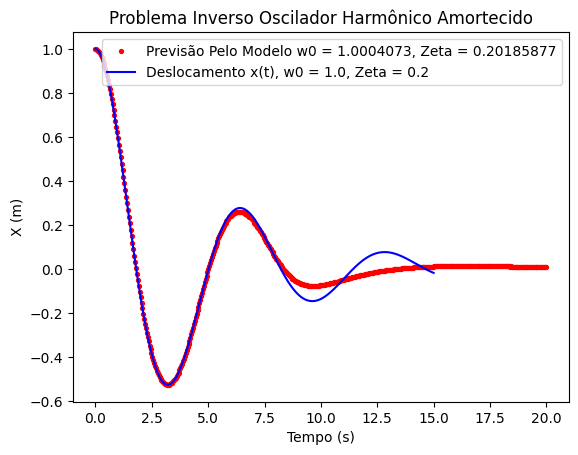

In [91]:
plt.plot(t2,prev,"ro",markersize=2.8,label="Previsão Pelo Modelo w0 = 1.0004073, Zeta = 0.20185877")
plt.plot(t, solution[:, 0], 'b-', label='Deslocamento x(t), w0 = 1.0, Zeta = 0.2')
plt.xlabel("Tempo (s)")
plt.ylabel("X (m)")
plt.title("Problema Inverso Oscilador Harmônico Amortecido")
plt.savefig("Osc_inverso.pdf")
plt.legend()
plt.show()